# <center>[😺🚀 Его бустейшество - **`CatBoost`**!](https://stepik.org/lesson/779917/)</center>

### Оглавление ноутбука

<img src='https://mljar.com/images/machine-learning/catboost.png' />
<br>

<p><font size="3" face="Arial" font-size="large"><ul type="square">
    
<li><a href="#c1">🛠 Catboost Classifier и его параметры </a></li>

<li><a href="#c2">📂 Настраиваем обучение по фолдам :</a></li>
<li><a href="#look1">🔧 Best practices по настройке Catboost </a>
<li><a href="#check1"> 🔋 "Батарейки в комплекте!"</a>
<li><a href="#check1">🤷‍ Другие параметры и режимы</a>

<li><a href="#6">🧸 Выводы и заключения</a>

</li></ul></font></p>



<div class="alert alert-info">
    

**`CatBoost`** — это open-source библиотека градиентного бустинга на решающих деревьях с поддержкой категориальных фичей из коробки, преемник алгоритма MatrixNet, разработанного Яндексом.<br>
В плане простоты использования и легкости входа для новичков, пожалуй является топ-1 библиотекой для табличных данных и вот почему:
* **Принимает категориальные фичи** сразу без всякой предварительной обработки.
* Чтобы перенести обучение с **`CPU`** на **`GPU`** достаточно поменять значение 1 параметра, без установки доп.пакетов или специальных версий, как в других библиотеках
* Даже с дефолтными параметрами выдает хорошую точность модели
  * Основные параметры не константные, а **подбираются самой библиотекой**, в зависимости от размера входных данных.
* Может принимать текстовые признаки, эмбеддинги, временные признаки.
* Без дополнительных манипуляций и оберток встраивается в стандартные пайплайны (например, **sklearn**).
* Идет в комплекте с "батарейками": **`feature_selection`**, **object_selection**, **cross_validation**, **grid_search** и пр.

<div class="alert alert-info">

**Из минусов: (почти нет)**
* Не умеет обрабатывать пропуски в данных (Сами избавляемся или заполняем `NaN` перед подачей в модель).
* Не все метрики и лоссы доступны при обучении на **`GPU`**.
* Не умеет делать кофе

<div class="alert alert-info">

**В общем, рекомендуем начинать всегда именно с этой библиотеки, особенно, если только начинаете вкатываться в соревнования.<br>
Алгоритм примерно следующий:**

1. Скачали данные
2. Провели быстрый EDA
3. Собрали список кат-фичей, закинули данные в **`CatBoost`**
4. Посмотрели, что модель дает с дефолтными фичами и параметрами. (baseline)
5. Отправили сабмишен на лидерборд.
6. Начинаем настройку валидации, **feature engeneering**, **тюнинг модели**, прочие манипуляции и танцы с бубном.

In [ ]:
!pip install seaborn catboost -q

import numpy as np
import pandas as pd


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.2 MB/s eta 0:00:00


# <center> Импортируем `train` датасет

train (2337, 17)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
153,e-1657282o,Nissan Qashqai,standart,petrol,5.78,2015,93706,2017,38.39,engine_overheat,4.175690,9.684176e+06,0.10,195.871509,9.120053,174,173
2069,M17938835z,Skoda Rapid,economy,petrol,3.32,2015,94780,2016,43.00,wheel_shake,4.589368,9.979294e+06,0.10,119.000000,27.495164,174,173
311,Q19568266H,VW Polo,economy,petrol,4.02,2013,42984,2015,27.81,break_bug,5.444540,1.598020e+07,0.38,116.465974,-8.650700,174,173


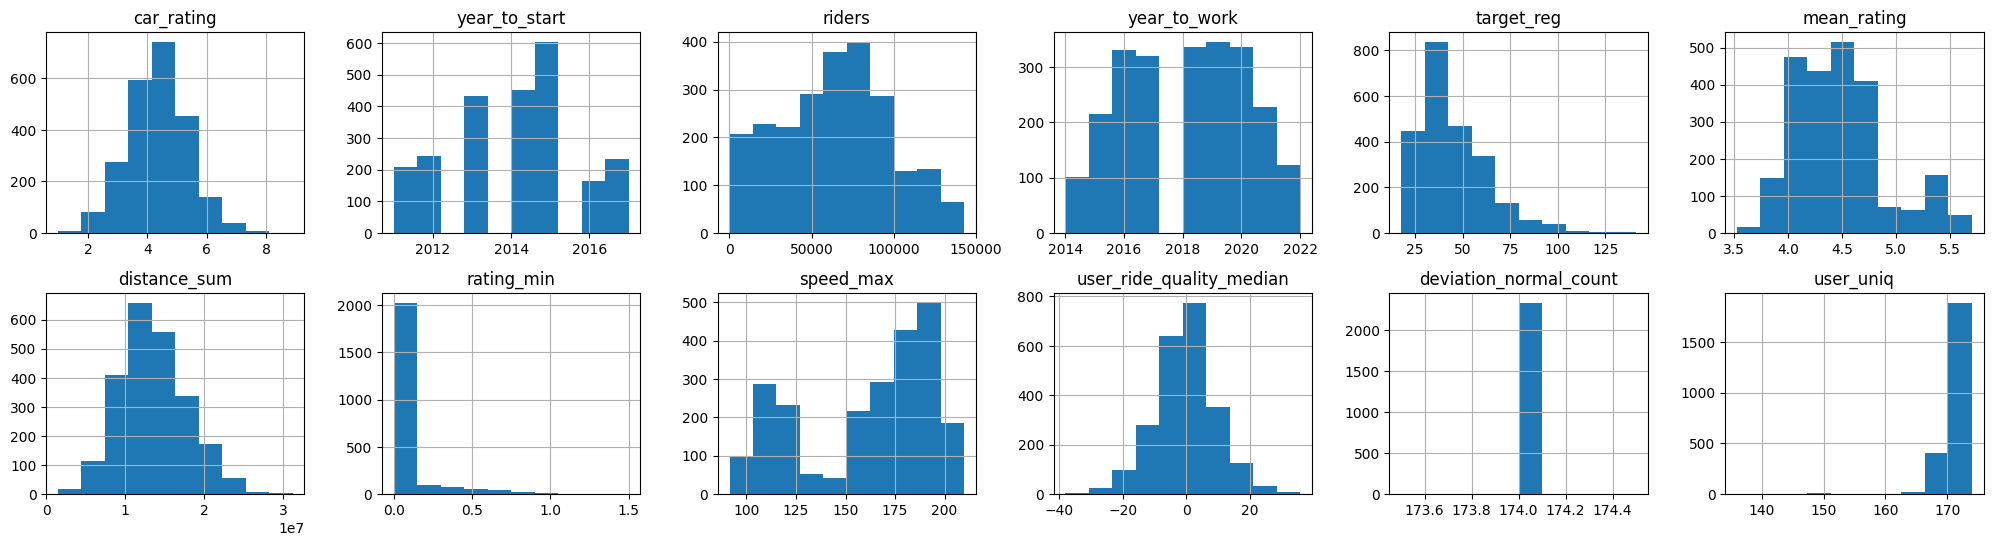

In [ ]:
data_root = "https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/"
path = data_root + "quickstart_train.csv"
train = pd.read_csv(path)

print("train", train.shape)
train.hist(figsize=(25, 6), layout=(-1, 6))
train.sample(3)

# <center> Группируем признаки и отбираем категориальные

In [ ]:
cat_features = ["model", "car_type", "fuel_type"]  # Выделяем категориальные признаки
targets = ["target_class", "target_reg"]
features2drop = ["car_id"]  # эти фичи будут удалены

# Отбираем итоговый набор признаков для использования моделью
filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

print("cat_features", cat_features)
print("num_features", len(num_features))
print("targets", targets)

for c in cat_features:  # Избавлеямся от NaN'ов
    train[c] = train[c].astype(str)

cat_features ['model', 'car_type', 'fuel_type']
num_features 11
targets ['target_class', 'target_reg']


# <center> **`CatBoost`** **`Classifier`** и его параметры

<p id="c1"></p>    
<div class="alert alert-info">

Задача - использовать  **`CatBoost`** для классификации поломок. Посмотрим, сможет ли алгоритм справиться с поставленной задачей.

Перед использованием рассмотрим параметры модели ([подробнее читай здесь](https://catboost.ai/en/docs/references/training-parameters/common)):

In [ ]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

In [ ]:
# Какие параметры есть в Catboost? посмотрим через shift + Tab
CatBoostClassifier()

<div class="alert alert-info">
    
**Базовые параметры**
    
* `iterations` (синонимы `num_boost_round`, `n_estimators`, `num_trees`) - максимальное количество деревьев, используемых в модели (по умолчанию **`1000`**). <br>
    Значение может быть ниже заданного, если используются другие параметры, накладывающие ограничение на количество деревьев;
* `learning_rate` или `eta` – скорость обучения, которая определяет насколько быстро или медленно модель будет учиться. Значение по умолчанию обычно равно **`0.03`**.
* `depth (max_depth)` - глубина дерева (по умолчанию 6, максимальное значение - 16);
* `cat_features` - список наименований категориальных признаков;

**Режим обучения**

* `loss_function` или `objective`- функция потерь, которую надо минимизировать при обучении. Есть показатели для регрессии (среднеквадратичная ошибка), есть для классификации (`logloss`).
* `eval_metric` - валидационная метрика, используемая для обнаружения переобучения и ранней остановки (в зависимости от задачи ссылки здесь);
* `custom_metric` - отслеживаемые метрики (список доступен здесь). Лучшие метрики в процессе обучения можно вернуть методом `get_best_score`;
* `early_stopping_rounds` - определяет число итераций до остановки, если на их протяжении метрика качества не улучшалась по сравнению с оптимальной;
* `use_best_model` - если **`True`**, в результате обучения с ранней остановкой будет возвращаться модель, полученная на итерации (количеством деревьев) с лучшей метрикой на валидационной выборке;

<div class="alert alert-info">
    
**Регуляризация модели, ускоряющие и обобщающие модель**
    
* `l2_leaf_reg` (или `reg_lambda`) – коэффициент при члене регуляризации **`L2`** функции потерь. Значение по умолчанию – **`3.0`**.
* `min_data_in_leaf (min_child_samples)` -  это минимальное количество обучающих сэмплов в листе.
* `max_leaves (num_leaves)` - максимальное количество листьев в дереве.
* `subsample` - часть исходной выборки, отбираемая для обучения каждого дерева;
* `colsample_bylevel` - доля признаков, используемая для отбора на каждом сплите;
* `max_bin` - максимальное число бинов, на которые разбиваются признаки
    

**Полезно использовать**    
    
* `random_seed` или `random_state` – инициализирующее значение для используемого генератора случайных чисел, чтобы обеспечить воспроизводимость эксперимента;
* `task_type` - используемое для вычислений устройство (**`CPU`**, **`GPU`**);
* `thread_count` - число используемых для обучения потоков (по умолчанию = **`-1`**, что означает - все ядра процессора);
* `verbose` - объем выводимой информации (**`False`** - подавляем сообщения).

<div class="alert alert-info">

**Балансировка классов**

* `class_weights` - веса классов в моделях классификации. Используется для устранения дисбаланса (например, вес `positive`= `количество_negative`/`количество_positive`);
* `classes_count` - количество классов для многоклассовой классификации;
* `auto_class_weights` - устраняет дисбаланс автоматически (значения - **`Balanced`**, **`SqrtBalanced`**);
* `scale_pos_weight` - задает вес для положительного класса; Среди параметров `scale_pos_weight`, `auto_class_weights`, `class_weights` одновременно используется только один.

## <center> Для начала обучим **`CatBoost`** с параметрами по умолчанию:

In [ ]:
from sklearn.model_selection import train_test_split

X = train[filtered_features].drop(targets, axis=1, errors="ignore")
y = train["target_class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
clf = CatBoostClassifier(thread_count=-1,
                         random_seed=42,
                         cat_features=cat_features)

clf.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

Learning rate set to 0.109335
0:	learn: 1.8108068	test: 1.8310378	best: 1.8310378 (0)	total: 90ms	remaining: 1m 29s
200:	learn: 0.2789378	test: 0.5441162	best: 0.5374049 (156)	total: 8.77s	remaining: 34.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5374048663
bestIteration = 156

Shrink model to first 157 iterations.


<div class="alert alert-info">
    
Видим, что **`CatBoost`** сам установил параметр `learning_rate = 0.109335` <br>
Теперь давайте поменяем количество деревьев.

In [ ]:
clf = CatBoostClassifier(iterations=100,
                         thread_count=-1,
                         random_seed=42,
                         cat_features=cat_features)

clf.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=10,
    use_best_model=True,
    early_stopping_rounds=50,
)

Learning rate set to 0.263488
0:	learn: 1.5180267	test: 1.5292177	best: 1.5292177 (0)	total: 25.2ms	remaining: 2.49s
10:	learn: 0.5942287	test: 0.6609974	best: 0.6609974 (10)	total: 271ms	remaining: 2.19s
20:	learn: 0.5086990	test: 0.6046452	best: 0.6046452 (20)	total: 540ms	remaining: 2.03s
30:	learn: 0.4489243	test: 0.5761154	best: 0.5761154 (30)	total: 801ms	remaining: 1.78s
40:	learn: 0.4020685	test: 0.5688007	best: 0.5684894 (33)	total: 1.06s	remaining: 1.53s
50:	learn: 0.3600712	test: 0.5740101	best: 0.5681639 (46)	total: 1.32s	remaining: 1.27s
60:	learn: 0.3375750	test: 0.5737759	best: 0.5681639 (46)	total: 1.59s	remaining: 1.02s
70:	learn: 0.3129667	test: 0.5697338	best: 0.5678971 (68)	total: 1.86s	remaining: 758ms
80:	learn: 0.2922667	test: 0.5678989	best: 0.5657195 (76)	total: 2.12s	remaining: 497ms
90:	learn: 0.2685586	test: 0.5679290	best: 0.5657195 (76)	total: 2.37s	remaining: 235ms
99:	learn: 0.2537216	test: 0.5724496	best: 0.5657195 (76)	total: 2.63s	remaining: 0us

best

<div class="alert alert-info">
    
Число деревьев уменьшили вдвое и `learning_rate` тоже пересчитался - стал больше: `0.14248`. Он так же зависит не только от числа деревьев но и пересчитывается под размеры датасета - это одна из крутых фишек CatBoost, и поэтому он может выдавать хорошую точность из коробки. Чтобы посмотреть другие гиперпараметры модели и как они меняются можно вызвать метод: `clf.get_all_params()`

In [ ]:
# Посмотрим на feature importance с помощью встроенного метода
# Не забываем про параметр prettified, чтобы список вывелся в виде красивой таблицы
clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,speed_max,34.336544
1,mean_rating,34.158117
2,rating_min,13.206289
3,model,4.214882
4,user_uniq,2.792148
5,car_type,2.422167
6,user_ride_quality_median,2.215881
7,distance_sum,2.068688
8,riders,1.730535
9,year_to_work,1.185616


<p id='c2'></p>

# <center> Настраиваем обучение по фолдам

In [ ]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import KFold  # k-фолдная валидация

In [ ]:
n_splits = 3  # Число фолдов. Оптимально 3, 5 или 10
clfs = [] # Тут будем сохранять модели
scores = [] # Тут будем хранить скоры валидационных фолдов

# параметры валидации, обучение будет идти на n_splits фолдах
X = train[filtered_features].drop(targets, axis=1, errors="ignore")
y = train["target_class"]

kf = KFold(n_splits=n_splits, shuffle=True, random_state=7575)
for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Специальный класс для ускорения обучения
    train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
    eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)

    clf = CatBoostClassifier(
        depth=4,
        iterations=3500,
        learning_rate=0.06,
        loss_function="MultiClass",  # MultiLogloss
        # eval_metric = 'Precision',  F1:macro / AUC:hints=skip_train~false
        custom_metric=["Recall"],  # 'AUC / Accuracy,

        # Главная фишка катбуста - работа с категориальными признаками
        cat_features=cat_features,
        # ignored_features = ignored_features,

        # Регуляризация и ускорение
        colsample_bylevel=0.098,
        subsample=0.95,
        l2_leaf_reg=9,
        min_data_in_leaf=243,
        max_bin=187,
        random_strength=1,

        # Параметры скорения
        task_type="CPU",
        thread_count=-1,
        bootstrap_type="Bernoulli",

        # Важное!
        random_seed=7575,
        auto_class_weights="SqrtBalanced",
        early_stopping_rounds=50)

    clfs.append(clf)

    clf.fit(
        train_dataset,
        eval_set=eval_dataset,
        verbose=500,
        use_best_model=True,
        plot=False)

    scores.append(np.mean([v for k, v in clf.best_score_["validation"].items() if "Recall" in k], dtype="float16"))
    # scores.append(clf.best_score_['validation']['MultiClass'])
    # clf.save_model("../tmp_data/cool_catboost_model_{}_deep".format(n))

assert len(clfs) == n_splits
print("mean Recall score --------->", np.mean(scores, dtype="float16") - np.std(scores, dtype="float16"))

0:	learn: 2.1956073	test: 2.1958090	best: 2.1958090 (0)	total: 1.84ms	remaining: 6.45s
500:	learn: 0.4702692	test: 0.5569354	best: 0.5569354 (500)	total: 1.24s	remaining: 7.43s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5096496804
bestIteration = 916

Shrink model to first 917 iterations.
0:	learn: 2.1951404	test: 2.1964014	best: 2.1964014 (0)	total: 1.79ms	remaining: 6.26s
500:	learn: 0.4909194	test: 0.5563577	best: 0.5562080 (497)	total: 1.23s	remaining: 7.39s
1000:	learn: 0.3967000	test: 0.5050570	best: 0.5050184 (997)	total: 2.45s	remaining: 6.12s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4961039188
bestIteration = 1241

Shrink model to first 1242 iterations.
0:	learn: 2.1956876	test: 2.1960187	best: 2.1960187 (0)	total: 1.84ms	remaining: 6.43s
500:	learn: 0.4706323	test: 0.5434797	best: 0.5434797 (500)	total: 1.18s	remaining: 7.05s
1000:	learn: 0.3921691	test: 0.5102073	best: 0.5102073 (1000)	total: 2.37s	remaining: 5.92s
Stopped 

In [ ]:
clf.best_score_['validation']

<p id="c3"></p>    
    
# <center>🤹‍📈 **`Best practices`** по настройке **`Catboost`**

<div class="alert alert-info">
    
- 🍏 Категориальные признаки помещать в `cat_features`. Сами не кодируем.
-  ⚠️ Фиксируем `random_seed` модели и разбиения. (В идеале, порядок фичей тоже)
- 🍏 Помещать данные в `Pool` для ускорения. (Квантилизация заранее)
- 🎓 Иметь `eval_set`, чтобы выставить `early_stopping_rounds`
- 🍏 Регуляризационные параметы `l2_leaf_reg`, `colsample_bylevel`, `subsample` и другие
- 🎓 `max_depth` как можно меньше при том же уровне точности
- 🍏 `iterations` должен быть с запасом для срабатывания `early_stopping_rounds`
- 🎓 `learning_rate` подбирается по метрике.
- 🍏 Метрика та, что заявленна в чемпионате. (**Recall**, **MAE**, **Корреляция** ...)
- ⚠️ Оцениваем модель по **`score = mean(metrics) - std(metrics)`**!
- 📈 Иногда записываем значения метрики локально и их значение на лидерборде.
    


# <center> Анализ и интерпретация модели
    
<div class="alert alert-info">
    
Полезный кусочек кода, который полезно использовать для визуализации.

Всего признаков 14 Усреднее по 3-ти моделям: 
На график нанесено топ-13 признаков


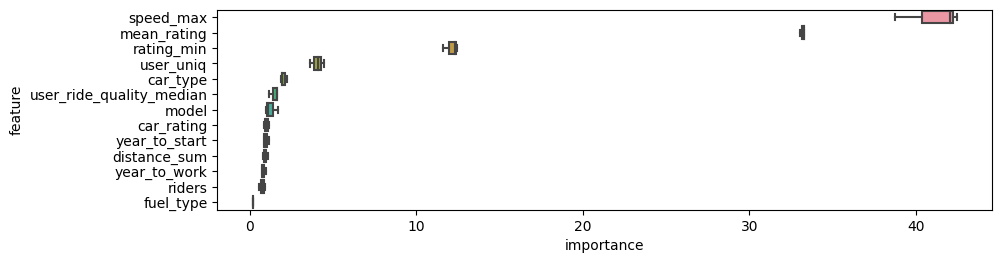

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_importance(df, best_model, height = 0.2, top_n=50):

    fi = pd.DataFrame(index=df.columns, columns=[])
    for i, m in enumerate(best_model):
        fi[f"m_{i}"] = m.get_feature_importance()

    fi = fi.stack().reset_index().iloc[:, [0, 2]]  # .to_frame()
    fi.columns = ["feature", "importance"]

    cols_ord = list(fi.groupby("feature")["importance"].mean().sort_values(ascending=False).index)

    print("Всего признаков {} Усреднее по {}-ти моделям: ".format(len(cols_ord), len(best_model)))
    cols_ord = cols_ord[:top_n]

    fi = fi[fi["feature"].isin(cols_ord)]

    plt.figure(figsize=(10, len(cols_ord) * height))
    b = sns.boxplot(data=fi, y="feature", x="importance", orient="h", order=cols_ord)

    print("На график нанесено топ-{} признаков".format(top_n))
    return (
        fi.groupby(by=["feature"], as_index=False)["importance"]
        .mean()
        .sort_values(by="importance", ascending=False))


df_feats_imp = plot_importance(
    train[filtered_features].drop(targets, axis=1, errors="ignore"),
    best_model = clfs,
    height = 0.20,
    top_n=13,
)

## <center>**`Feature Importance`** с помощью **Shap**.</center>

[Ссылка на документацию Shap](https://shap.readthedocs.io/en/latest/)

In [ ]:
!pip install catboost -q
!pip uninstall opencv-python -y -q
!pip install opencv-python shap -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 38.8 MB/s eta 0:00:00


In [ ]:
import shap

shap.initjs()

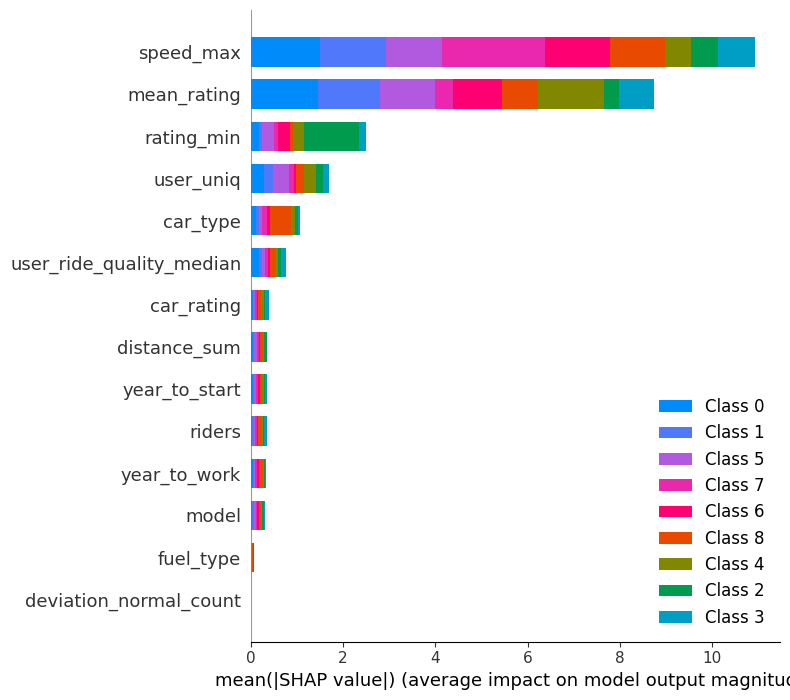

In [ ]:
explainer = shap.TreeExplainer(clfs[-1])

train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
shap_values = explainer.shap_values(train_dataset)

shap.summary_plot(shap_values, X_train, max_display=25)

# <center> Теперь произведем инференс модели

In [ ]:
# dir(clf)

In [ ]:
path = data_root + "quickstart_test.csv"
sub = pd.read_csv(path)

# массив для записи финального прогноза size*n_class
y_pred = np.zeros((sub.shape[0], train[targets].nunique()[0]))

# Пробегаемся по моделям каждого фолда и дергаем прогноз
for n, clf in enumerate(clfs):
    y_pred += clf.predict_proba(sub[filtered_features])

f = lambda x: clf.classes_[x]
sub["target_class"] = list(map(f, y_pred.argmax(axis=1)))

#sub[["car_id", "target_class"]].to_csv("../subs/catboost_kfold.csv", index=False)
sub[["car_id", "target_class"]].to_csv("catboost_kfold.csv", index=False)
sub[["car_id", "target_class"]].head()

,car_id,target_class
0,P17494612l,engine_overheat
1,N-1530212S,electro_bug
2,B-1154399t,break_bug
3,F12725233R,gear_stick
4,l-1139189J,electro_bug


# <center>🔋 "Батарейки в комплекте!" </center>

<div class="alert alert-info">

Ещё одной важной особенностью **`CatBoost`** является большой набор полезных встроенных функций (батареек): всё что нужно внутри одного фрэймворка:

* **Recursive Feature Selection** (рассматривался в ноутбуке по **Feature Selection**)
* **Object Selection** - отбор объектов для обучения. Удаляются "вредные".
* Подбор оптимальных гиперпараметров (**Grid search**)
* [Кросс-валидация](https://github.com/catboost/tutorials/tree/master/cross_validation)
* Обработка текстов и эмбеддингов

Посмотрим на некоторые из этих функций.

## <center> **`Object importance`** или удаляем вредные примеры </center>

<div class="alert alert-info">
    
**Object importance** - позволяет оценить влияние каждого элемента обучающей выборки на значение целевой метрики (`eval_metric`). Т.е. с помощью этой функции можно найти и избавиться от выбросов, шума и прочего мусора в тренировочном датасете.

На данный момент расчет **object importance** доступен только для некоторых лосс-функций:

`Logloss`, `CrossEntropy`, `RMSE`, `MAE`, `Quantile`, `Expectile`, `LogLinQuantile`, `MAPE`, `Poisson`

В списке нет `MultiLogloss` поэтому для задачи мультиклассификации нельзя его рассчитать. Рассмотрим на примере регрессии.


In [ ]:
X = train[filtered_features].drop(targets, axis=1, errors="ignore")
y = train["target_reg"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# Обучим модель регрессии
model = CatBoostRegressor(
    random_seed=42, thread_count=-1, cat_features=cat_features, eval_metric="RMSE"
)

model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=100,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

Learning rate set to 0.056174
0:	learn: 17.0065561	test: 17.7387430	best: 17.7387430 (0)	total: 3.13ms	remaining: 3.13s
100:	learn: 10.5043228	test: 12.2090243	best: 12.2090243 (100)	total: 231ms	remaining: 2.05s
200:	learn: 9.3900288	test: 12.1591227	best: 12.1374989 (148)	total: 468ms	remaining: 1.86s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 12.1374989
bestIteration = 148

Shrink model to first 149 iterations.


<div class="alert alert-info">
    
Рассмотрим основные параметры метода `get_object_importance`: <br>
```python
get_object_importance(pool,
                      train_pool,
                      top_size=-1, # число возвращаемых наиболее важных объектов из трэйн датасета (-1 без ограничений)
                      type='Average', # тип вычисления `Average` или `PerObject` - второй тип дольше
                      importance_values_sign='All' # `Positive`, `Negative`, `All` - зависит от оптимизируемой метрики
                      update_method='SinglePoint', # `SinglePoint` — быстрейший, `TopKLeaves`, `AllPoints` — Самый медленный и самый точный метод.
                      )
```

In [ ]:
# метод возвращает отсортированные списки индексов и скоров
idxs, scores = model.get_object_importance(
    test_pool, train_pool, importance_values_sign="Positive", thread_count=-1
)
len(idxs)

1070

In [ ]:
# Нашлось 1070 объектов которые увеличивают нашу RMSE, посмотрим на топ-20
scores[:20]

[1.0760798660350779,
 0.6217592053237175,
 0.28241900661358055,
 0.24956990727651696,
 0.2473919563486811,
 0.24435693957510338,
 0.22605544242815276,
 0.222093088614638,
 0.21411728044697934,
 0.20855406342759,
 0.20814361321622363,
 0.20165304798163927,
 0.2009990077614598,
 0.20085475767541583,
 0.1902886505182502,
 0.18728240775813945,
 0.18727006159768447,
 0.1854390466216923,
 0.18382276655258728,
 0.1773868133984341]

In [ ]:
# Попробуем отбросить топ-100 найденных, и посмотрим как изменится точность
train_pool = Pool(
    X_train.reset_index(drop=True).drop(idxs[:100]),
    y_train.reset_index(drop=True).drop(idxs[:100]),
    cat_features=cat_features,
)

model = CatBoostRegressor(
    random_seed=42, thread_count=-1, cat_features=cat_features, eval_metric="RMSE"
)

model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=100,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

Learning rate set to 0.055692
0:	learn: 16.7940672	test: 17.7337852	best: 17.7337852 (0)	total: 2.85ms	remaining: 2.85s
100:	learn: 9.5267039	test: 11.6210027	best: 11.6210027 (100)	total: 238ms	remaining: 2.12s
200:	learn: 8.5490724	test: 11.6513031	best: 11.5690115 (127)	total: 465ms	remaining: 1.85s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 11.56901147
bestIteration = 127

Shrink model to first 128 iterations.


<div class="alert alert-info">
    
`RMSE` уменьшилась на `~ 0.5`. Можете ещё поэкспериментировать с другими параметрами и отбрасыванием большего количества объектов.

## <center> Подбор оптимальных гиперпараметров. </center>

<div class="alert alert-info">

В CatBoost реализовано 2 метода подбора гиперпараметров модели `grid_search` и `randomized_search`. Как заявляют авторы фреймворка, методы оптимизированы и справляются с задачей быстрее, чем аналогичные из sklearn. [Grid search](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier_grid_search) просто перебирает параметры по заданной сетке, [randomized search](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier_randomized_search) берет рандомные сэмплы из заданного распределения.

Посмотрим пример с `randomized search`. В последующих модулях вы узнаете про более быстрыее и умные оптимизаторы гипер-параметров, но начать можно с этих.

In [ ]:
from scipy import stats

model = CatBoostRegressor(
    random_seed=42,
    thread_count=-1,
    cat_features=cat_features,
    eval_metric="RMSE",
    verbose=500,
)

param_distribution = {
    "one_hot_max_size": stats.bernoulli(p=0.2, loc=2),
    "learning_rate": [0.03, 0.1, 0.3],
    "l2_leaf_reg": [2, 5, 7],
    "depth": stats.binom(n=10, p=0.2),
}
randomized_search_result = model.randomized_search(param_distribution, X_train, y_train)
model.best_score_

0:	learn: 47.0641653	test: 45.9617985	best: 45.9617985 (0)	total: 850us	remaining: 850ms
500:	learn: 11.2594999	test: 10.9743290	best: 10.9743290 (500)	total: 346ms	remaining: 345ms
999:	learn: 10.7223143	test: 10.8167526	best: 10.8156375 (997)	total: 838ms	remaining: 0us

bestTest = 10.81563746
bestIteration = 997

0:	loss: 10.8156375	best: 10.8156375 (0)	total: 864ms	remaining: 7.77s
0:	learn: 47.0653639	test: 45.9527103	best: 45.9527103 (0)	total: 555us	remaining: 555ms
500:	learn: 12.4029998	test: 11.9040292	best: 11.9040292 (500)	total: 321ms	remaining: 320ms
999:	learn: 11.9554606	test: 11.6941156	best: 11.6933492 (998)	total: 811ms	remaining: 0us

bestTest = 11.69334924
bestIteration = 998

1:	loss: 11.6933492	best: 10.8156375 (0)	total: 1.69s	remaining: 6.75s
0:	learn: 47.0637038	test: 45.9507331	best: 45.9507331 (0)	total: 298us	remaining: 298ms
500:	learn: 17.7531225	test: 16.4482459	best: 16.4343660 (137)	total: 95.1ms	remaining: 94.7ms
999:	learn: 17.7531225	test: 16.448246

{'learn': {'RMSE': 9.933556873779514}}

In [ ]:
# Лучшие параметры модели из перебора
randomized_search_result["params"]

{'l2_leaf_reg': 5,
 'depth': 3.0,
 'one_hot_max_size': 2.0,
 'learning_rate': 0.03}

# <center> 🎓Какие еще полезные параметры есть в **`Catboost`**?

<div class="alert alert-info">

**Многие знают, что такое `random_seed`, `learning_rate`, `iterations`, поэтому обсудим другие:**
* `boosting_type` – это тип бустинга, который используется при обучении
  * значение **Plain** дает качество хуже, но работает быстрее
  * есть другой более затратный тип — **Ordered**, но дает лучшее качество (только для небольших датасетов).
* `bootstrap_type` –  определяет метод сэмплинга весов объектов. Когда мы строим дерево, построение идет не по всем объектам обучающей выборки, а по нескольким объектам. Это может быть Байес, Бернулли, многомерная случайная величина или Пуассон.
* `subsample` – это вероятность, по которой будет выбираться каждый объект для построения дерева. Параметры `bootstrap_type` и `subsample` идут в связке.
* `one_hot_max_size` – это горячее кодирование определенных переменных выборки (конвертируем каждое категориальное значение в новый категориальный столбец и присваиваем этим столбцам двоичное значение 1 или 0).
* `RSM` - он аналогичен `subsample`, только используется **для фичей, а не объектов**.
* `leaf_estimation_iterations` – это количество итераций подсчета значений в листьях.
* `max_ctr_complexity` – это длина перебора комбинаций фичей из данной выборки. Разделение ветвей не только по отдельным признакам, ***но и по их комбинациям - одна из ключевых особенностей CatBoost.***

In [ ]:
from catboost import CatBoost

fast_model = CatBoostClassifier(
    random_seed=63,
    iterations=150,
    learning_rate=0.01,
    boosting_type="Plain",
    bootstrap_type="Bernoulli",
    subsample=0.5,
    one_hot_max_size=20,
    rsm=0.5,
    # cat_features = cat_features,
    leaf_estimation_iterations=5,
    max_ctr_complexity=1,
    early_stopping_rounds=10,
)

fast_model.fit(
    train_dataset,
    eval_set=eval_dataset,
    verbose=100,
    # plot=True
);

0:	learn: 2.1616973	test: 2.1612391	best: 2.1612391 (0)	total: 15.7ms	remaining: 2.34s
100:	learn: 0.8112038	test: 0.8361220	best: 0.8361220 (100)	total: 2.4s	remaining: 1.16s
149:	learn: 0.6690084	test: 0.7050471	best: 0.7050471 (149)	total: 3.27s	remaining: 0us

bestTest = 0.7050471238
bestIteration = 149



# <center> Какие параметры использовались в модели?

In [ ]:
fs2noshow = [
  "boosting_type","boosting_type","max_ctr_complexity","leaf_estimation_iterations", "rsm","one_hot_max_size",
    "subsample", "depth","task_type","eval_metric","iterations", "loss_function","min_data_in_leaf",
    "learning_rate", "auto_class_weights","classes_count", "random_seed","l2_leaf_reg",
]

for key, value in fast_model.get_all_params().items():
    if key not in fs2noshow:
        print("{}, {}".format(key, value))

nan_mode, Min
combinations_ctr, ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=8:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']
sampling_frequency, PerTree
fold_permutation_block, 0
leaf_estimation_method, Newton
od_pval, 0
random_score_type, NormalWithModelSizeDecrease
counter_calc_method, SkipTest
grow_policy, SymmetricTree
penalties_coefficient, 1
model_shrink_mode, Constant
feature_border_type, GreedyLogSum
ctr_leaf_count_limit, 18446744073709551615
bayesian_matrix_reg, 0.10000000149011612
eval_fraction, 0
force_unit_auto_pair_weights, False
random_strength, 1
od_type, Iter
boost_from_average, False
model_size_reg, 0.5
simple_ctr, ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=8:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']
pool_metainfo_options, {'tags': {}}
use_best_model, True
od_wait, 1

# <center> Давайте рассмотрим параметры в **`CatBoost`**, которые еще не обсуждали:

<div class="alert alert-info">
    
**Режимы построения дерева (политика роста)**
    
`grow_policy` – определяет, как будет применяться жадный алгоритм поиска. Может стоять в значении **`SymmetricTree`**, **`Depthwise`** или **`Lossguide`**. По умолчанию **`SymmetricTree`**.
  * **`SymmetricTree`** дерево строится уровень за уровнем, пока не достигнет необходимой глубины. На каждом шаге листья с предыдущего дерева разделяются с тем же условием. При выборе параметра
  * **`Depthwise`** дерево строится шаг за шагом, пока не достигнет необходимой глубины. Листья разделяются с использованием условия, которое приводит к лучшему уменьшению потерь.
  * **`Lossguide`** дерево строится по листьям до тех пор, пока не будет достигнуто заданное количество листьев. На каждом шаге разделяется нетерминальный лист с лучшим уменьшением потерь. lightGBM
    

**Напоминание:**

* `min_data_in_leaf` или `min_child_samples` – это минимальное количество обучающих сэмплов в листе. Этот параметр используется только с политиками роста **`Lossguide`** и **`Depthwise`**.
* `max_leaves` или `num_leaves` – этот параметр используется только с политикой **`Lossguide`** и определяет количество листьев в дереве.

<div class="alert alert-info">

**Пропуски в численных фичах**
    
* `nan_mode` – метод работы с пропущенными значениями.
  * Параметры **`Forbidden`**, **`Min`** и **`Max`**.
  * При использовании **`Forbidden`** наличие пропущенных значений вызовет ошибку.
  * При использовании параметра **`Min`** пропущенные значения будут приняты за максимальные значения для данного признака.
  * В **`Max`** пропущенные значения будут приняты как минимальные значения для данного признака.
    

### ⛄️ Параметров много. Про некоторые из них в другой раз

<div class="alert alert-info">
    
    
* `score_function` – тип оценки, используемой для выбора следующего разбиения при построении дерева.
  * **`Cosine`** используется по умолчанию.
  * Другие доступные варианты **`L2`**, **`NewtonL2`** и **`NewtonCosine`**.
    
* `leaf_estimation_backtracking` – тип бэктрекинга, использующийся при градиентном спуске. По умолчанию используется **`AnyImprovement`**.
  * **`AnyImprovement`** уменьшает шаг спуска до того, как значение функции потерь будет меньшим, чем оно было на последней итерации.
  * **`Armijo`** уменьшает шаг спуска до тех пор, пока не будет выполнено условие Вольфе.
* `text_features` — используется для объявления текстовых столбцов в задачах классификации.

# <center> Сохраняем и подгружаем модель

<div class="alert alert-info">
    
Сохранить обученную модель **`CatBoost`** можно в нескольких форматах - `json`, `cpp`, `onnx`. <br>
Однако, в `CatBoost` есть собственный формат для сохранения моделей `cbm` (**CatBoost binary format**), предпочтительно сохранять модели именно в этом формате.

In [ ]:
params = {
    "iterations": 100,
    "learning_rate": 0.001,
    "depth": 7,
    "bootstrap_type": "Bernoulli",
    "subsample": 0.9,
    "random_seed": 7575,
}


clf = CatBoostClassifier(**params)

clf = clf.fit(train_dataset, eval_set=eval_dataset, verbose=False)

print(clf.get_params())

{'iterations': 100, 'learning_rate': 0.001, 'depth': 7, 'random_seed': 7575, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9}


In [ ]:
#model.save_model("../others/catboost_model.cbm", format="cbm")
model.save_model("catboost_model.cbm", format="cbm")  # format по умолчанию cbm поэтому можно явно не указывать

Теперь загрузим нашу модель и проверим параметры:

In [ ]:
new_clf = CatBoostClassifier()
#new_clf.load_model("../others/catboost_model.cbm")
new_clf.load_model("catboost_model.cbm")

In [ ]:
print(new_clf.get_params())

{'eval_metric': 'RMSE', 'verbose': 0, 'one_hot_max_size': 2, 'loss_function': 'RMSE', 'l2_leaf_reg': 5, 'depth': 3, 'random_seed': 42, 'learning_rate': 0.1}


# <center> Другие модели и режимы

<div class="alert alert-info">

* В рамках этого ноутбука мы рассмотрели только модель для классификации. Позже коснемся регрессии.   
* Катбуст может решать задачу мульти-классификация или даже мульти-лейбл классификации. (Меняется лосс-функция)
* Но библиотека так же содержит модель для решения задач ранжирования [**CatBoostRanker**](https://catboost.ai/en/docs/concepts/python-reference_catboostranker). <br>
* Пример решения [задачи мэтчинга с помощью CatBoostRanker на VTB DataFusionContest2022](https://github.com/Ivanich-spb/VTB_DataFusion_Contest_2022) от авторов курса.

# 🧸 Выводы и заключения

- 🧩 Катбуст мощный и многофункциональный фреймворк
- 🧩 Много параметров и тонкостей
- 🧩 Отличный вариант для старта
- 🧩 Полезно понимать принцип работы градиентных бустингов

# <center> Полезные источники

    
* [Очень подробная статья про работу Catboost, (если не знаете, как он работает)](https://habr.com/ru/company/ods/blog/645887/)
* [Работа с параметрами для категориальных фичей](https://towardsdatascience.com/categorical-features-parameters-in-catboost-4ebd1326bee5)
* [Трилогия Яндекса про катбуст. Часть 1](https://habr.com/ru/company/ods/blog/594077/) | [Часть 2](https://habr.com/ru/company/ods/blog/599827/) | [Часть 3](https://habr.com/ru/company/ods/blog/648939/)

# Home_work

In [ ]:
from sklearn.metrics import confusion_matrix
from scipy.special import expit
from numba import jit

In [ ]:
from sklearn.metrics import confusion_matrix
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
confusion_matrix(y_true, y_pred)

array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])

In [ ]:
class P4Metric(object):
    def get_final_error(self, error, weight):
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return True


    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]
        error_sum = 0.0
        all_songs = []
        all_true = []
        y_pred = 1 / (1 + np.exp(-approx))
        y_pred = y_pred > 0.5
        y_true = target
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        error_sum = (4*tp*tn)/(4*tp*tn + (tp+tn)*(fp + fn))

        return error_sum, 1

<ipython-input-30-35095390f6e3>:3: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_final_error(self, error, weight):


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

rides_info = pd.read_csv('/content/CB_bin_target_data.csv')
cat_cols = ['car_type', 'fuel_type', 'model']
X = rides_info.drop(['target_bin'], axis=1)
y = rides_info['target_bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostClassifier(random_state=42,
                           cat_features=cat_cols,
                           eval_metric=P4Metric())

model.fit(X_train, y_train, eval_set=(X_test, y_test),
                                      verbose=50, plot=False,
                                      early_stopping_rounds=100)


TypeError: ignored

Exception ignored in: '_catboost._BuildCustomMetricDescriptor'
Traceback (most recent call last):
  File "_catboost.pyx", line 1595, in _catboost._try_jit_methods
  File "_catboost.pyx", line 1549, in _catboost._try_jit_method
  File "_catboost.pyx", line 1522, in _catboost._is_self_unused_in_method
  File "/usr/lib/python3.10/inspect.py", line 1287, in getfullargspec
    raise TypeError('unsupported callable') from ex
TypeError: unsupported callable
/usr/local/lib/python3.10/dist-packages/catboost/core.py:1723: UserWarning: Failed to optimize method "evaluate" in the passed object:
Failed in nopython mode pipeline (step: nopython frontend)
Untyped global name 'confusion_matrix': Cannot determine Numba type of <class 'function'>

File "<ipython-input-30-35095390f6e3>", line 21:
    def evaluate(self, approxes, target, weight):
        <source elided>
        y_true = target
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        ^

  self._object._train(train_pool, te

Learning rate set to 0.036983
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 83.9ms	remaining: 1m 23s
50:	learn: 0.6618212	test: 0.5148397	best: 0.5148397 (50)	total: 389ms	remaining: 7.24s
100:	learn: 0.8116578	test: 0.5942377	best: 0.5989402 (92)	total: 697ms	remaining: 6.21s
150:	learn: 0.8649428	test: 0.6610884	best: 0.6610884 (145)	total: 1s	remaining: 5.63s
200:	learn: 0.8952646	test: 0.6438122	best: 0.6779758 (178)	total: 1.35s	remaining: 5.37s
250:	learn: 0.9362061	test: 0.6305286	best: 0.6779758 (178)	total: 1.7s	remaining: 5.08s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6779758482
bestIteration = 178

Shrink model to first 179 iterations.
